### Generate the Official cb-WoFS Explainability Graphics 

In [1]:
# Box and Whisker plot for the top 5 predictors 
# pink line for a given example. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from display_names import to_display_name, to_units
import sys
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.io.io import load_ml_data
from wofs.post.utils import load_yaml
import matplotlib.ticker as ticker

from sklearn.impute import SimpleImputer

In [2]:
def get_target_str(target):
    # Initialize the kwargs for the hyperparameter optimization.
    if isinstance(target, list):
        if 'sig_severe' in target[0]:
            target = 'all_sig_severe'
        else:
            target = 'all_severe'
   
    return target 

In [3]:
import math
import json 
import matplotlib.ticker as mtick

class cbWoFSExplainabilityGraphics:
    def __init__(self, X_train, y_train):
        
        # Only get where the examples are matched to reports.
        inds = np.where(y_train>0)[0]
    
        X_train_subset = X_train.iloc[inds, :]
        X_train_subset.reset_index(drop=True, inplace=True)
        
        #X_train_subset['mid_level_lapse_rate_ens_mean_spatial_mean'] /= -2.7
        #X_train_subset['low_level_lapse_rate_ens_mean_spatial_mean'] /= -3.0
        
        # Convert mid-level temps?  
        
        self.X_train = X_train_subset
        self.features = X_train_subset.columns 
        
        self.max_min_val_dict = { }
        
    def get_order_of_magnitude(self, value):
        return int(math.log10(abs(value)))
        
    def get_fontsize(self, value):
        """Get the fontsize based on order of magnitude."""
        try:
            oom = self.get_order_of_magnitude(value)
        except ValueError:
            return 10
            
        if oom <= -1:
            return 7
    
        elif oom > 2: 
            return 7
    
        else:
            return 10 
    
    def is_negatively_oriented(self, values):
        """Check if the value is negatively oriented (higher negative values are meaningful)"""
        # If the absolute value of the minimum is larger than the 
        # maximum value, then the values are negatively oriented. 
        if abs(np.min(values)) > np.max(values):
            return True
        else: 
            return False
    
    
    def _round(self, value, mode):

        def round_to_nearest_fifth(x):    
            if x < 0:
                return -round_to_nearest_fifth(-x)
            elif x < 10:
                return x
            else:
                if mode=='upper': 
                    return math.ceil(x / 5,) * 5
                else:
                    return math.floor(x / 5,) * 5
        
        if value == 0.0:
            return 0.0, 0
    
        # Find the order of magnitude (oom)
        oom = self.get_order_of_magnitude(value)
        
        #print(f'{oom=}')
        
        round_to_fifth = False
        if oom >= 0:
            # Positive Order of Mag. 
            if oom == 0:
                round_int = 2
            if oom == 1 :
                round_int = 1
                round_to_fifth = True
            elif oom > 1:
                round_int = 0
                round_to_fifth = True
        else:
            # Negative Order of Mag.
            if oom == -1:
                round_int = 3
            elif oom == -2:
                round_int = 4    
            else:
                round_int = 4
 
        # Round to the nearest 5 for >=10 
        if round_to_fifth:
            return round_to_nearest_fifth(round(value, round_int)), round_int
        else:
            return round(value, round_int), round_int

        
    def create_global(self, features, target):
        """Create the global explainability graphic"""
        f, axes = plt.subplots(dpi=192, nrows=5, 
                           figsize=(800/192, 800/192))
        for ax, feature in zip(axes, features):
            self.create_local(feature, ax=ax, f=f)
        
        title = f"""
        Training Set Distribution\n(All {target}-Producing Storms)\nfor the Top 5 Predictors (out of 113)"""
    
        f.suptitle(title, 
               fontsize=8, y=1.10)
        
        axes[0].set_title('Red numbers and vertical bars\nshow current values for this object', 
                      fontsize=6, pad=12, color='red')
        
        plt.subplots_adjust(hspace=1.4)
        
        return f, axes 
                
    def create_local(self, feature, target, f=None, ax=None):
        """Create box-and-whisker graphic for a single feature"""  
        units = to_units(feature)
        pretty_name = to_display_name(feature)
    
        if ax is None:
            f, ax = plt.subplots(dpi=192, nrows=1, 
                           figsize=(800/192, 100/192))
        
        # Despine and only leave the bottom side. 
        for side in ['top', 'right', 'left']: 
            ax.spines[side].set_visible(False)

        # Remove y tick labels 
        whis=[0.01, 99.9]
        ax.tick_params(axis='x', labelsize=9, size=8)
        
        # Check for negative values. 
        min_val, round_int_min = self._round(np.nanpercentile(self.X_train[feature], whis[0]), 'lower')
        max_val, round_int_max = self._round(np.nanpercentile(self.X_train[feature], whis[-1]), 'upper')
        
        round_int = round_int_min if self.is_negatively_oriented(self.X_train[feature]) else round_int_max
        
        self.max_min_val_dict[f'{feature}'] = {'round_int' : round_int}
        
        # Create the box-and-whiskers 
        box_plot = ax.boxplot(x=self.X_train[feature], vert=False, 
                              whis=whis, patch_artist=True, 
                              widths=0.3, showfliers=False )
        ax.set_yticks([],)
        
        # Create a title for the feature name. 
        ax.annotate(fr'{pretty_name} ({units})', xy=(0, 1.15),
                    xycoords='axes fraction', fontsize=6, ha='left', color = 'k', fontweight='bold')
            
        # Identify pretty tick ranges 
        ax.set_xlim(min_val, max_val)
        
        # set the tick locator for the x-axis
        #ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
        
        rng = list(ax.get_xticks())
        
        self.max_min_val_dict[f'{feature}_{target}'] = {'max_val' : rng[-1],
                                          'min_val' : rng[0], }
        
        # Identify pretty tick ranges 
        ax.set_xlim(rng[0], rng[-1])
        
        
        if round_int in [0,1]:
            labels = [f"{int(round(v, round_int))}" for v in rng]
        else:
            labels = [f"{round(v, round_int)}" for v in rng]
        
        labels[0] = ''; labels[-1] = ''
        
        high_val = np.max((abs(max_val), abs(min_val)))
        #print(f'{rng=}  {labels=} {max_val=}  {min_val=}')
        
        ax.set_xticklabels(labels=labels, fontsize=self.get_fontsize(high_val))

        # fill with colors
        color = 'xkcd:medium blue'
        for patch in box_plot['boxes']:
            patch.set_facecolor(color)
        for line in box_plot['medians']:
            line.set_color('k')

        return f, ax
    
    def save_local(self, fig, feature, target):
        plt.savefig(
            f"new_graphics/{feature}_{target}_explainability_background.png", 
            format="png", dpi=192, bbox_inches="tight", pad_inches=0.0)
        plt.close(fig) 
    
    def save_global(self, fig, target):
        plt.savefig(
            f"new_graphics/{target}_global_explainability_background.png", 
            format="png", dpi=192, bbox_inches="tight", pad_inches=0.0)
        plt.close(fig) 
    
    
    def save_json(self, target): 
        with open(f"../json/min_max_vals_{target}.json", "w") as outfile:
            json.dump(self.max_min_val_dict, outfile)

### Test a Single Individual Panel

In [5]:
%matplotlib inline
target = 'hail_severe_0km'

data = joblib.load(
    '/work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_tornado_severe_0km_None_first_hour_realtime.joblib')
features = data['X'].columns

target_str = get_target_str(target)
print(target_str.upper())
df, y_train, metadata = load_ml_data(target, 
                 lead_time = 'first_hour', 
                 mode = 'training', 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )
X_train = df[features]            
        
# Impute missing values. 
X_train = pd.DataFrame(SimpleImputer().fit_transform(X_train), columns=X_train.columns)

HAIL_SEVERE_0KM


In [6]:
list(features)

['u_10__ens_mean__spatial_mean',
 'v_10__ens_mean__spatial_mean',
 'mid_level_lapse_rate__ens_mean__spatial_mean',
 'low_level_lapse_rate__ens_mean__spatial_mean',
 'srh_0to1__ens_mean__spatial_mean',
 'srh_0to3__ens_mean__spatial_mean',
 'shear_u_0to6__ens_mean__spatial_mean',
 'shear_v_0to6__ens_mean__spatial_mean',
 'shear_u_0to1__ens_mean__spatial_mean',
 'shear_v_0to1__ens_mean__spatial_mean',
 'uh_0to2_instant__time_max__ens_mean__spatial_mean',
 'uh_2to5_instant__time_max__ens_mean__spatial_mean',
 'wz_0to2_instant__time_max__ens_mean__spatial_mean',
 'comp_dz__time_max__ens_mean__spatial_mean',
 'ws_80__time_max__ens_mean__spatial_mean',
 'w_up__time_max__ens_mean__spatial_mean',
 'hailcast__time_max__ens_mean__spatial_mean',
 'w_1km__time_max__ens_mean__spatial_mean',
 '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
 'dbz_3to5__time_max__ens_mean__spatial_mean',
 'dbz_1to3__time_max__ens_mean__spatial_mean',
 'ctt__time_min__ens_mean__spatial_mean',
 'buoyancy__time_min

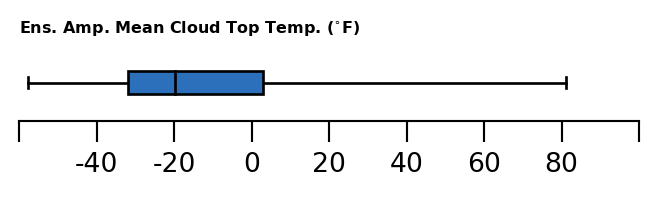

In [8]:
%matplotlib inline
feature = 'ctt__time_min__amp_ens_mean_spatial_perc_10'

explainer = cbWoFSExplainabilityGraphics(X_train.astype(float), y_train)
fig, _ = explainer.create_local(feature, target_str)

#explainer.save_local(fig, feature, target_str)

### Create Individual Panels for All Features Per Hazard

In [9]:
targets = ['wind_severe_0km', 
           'hail_severe_0km', 
           'tornado_severe_0km', 
           ['wind_severe_0km', 'hail_severe_0km', 'tornado_severe_0km'],
           ['wind_sig_severe_0km', 'hail_sig_severe_0km', 'tornado_sig_severe_0km']
          ]

data = joblib.load(
    '/work/mflora/ML_DATA/NEW_ML_MODELS/LogisticRegression_tornado_severe_0km_None_first_hour_realtime.joblib')
features = data['X'].columns

for target in targets:
    target_str = get_target_str(target)
    print(target_str.upper())
    df, y_train, metadata = load_ml_data(target, 
                 lead_time = 'first_hour', 
                 mode = None, 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )
    X_train = df[features]            
         
    # Impute missing values. 
    X_train = pd.DataFrame(SimpleImputer().fit_transform(X_train), columns=X_train.columns)
        
    explainer = cbWoFSExplainabilityGraphics(X_train.astype(float), y_train)
    
    for feature in X_train.columns: 
        fig, _ = explainer.create_local(feature, target_str)
        explainer.save_local(fig, feature, target_str)
        
    explainer.save_json(target_str)    

WIND_SEVERE_0KM
HAIL_SEVERE_0KM
TORNADO_SEVERE_0KM
ALL_SEVERE
ALL_SIG_SEVERE


In [ ]:
X_train.shape

In [ ]:
# Save all the jsons together! 
from glob import glob
files = glob("../json/min_max_vals*")
pd.read_json(files[0])

In [ ]:
top_preds = {'tornado_severe_0km' : 
            ['wz_0to2_instant__time_max__amp_ens_mean_spatial_perc_90', 
             'shear_v_0to6__ens_mean__spatial_mean',
             'buoyancy__time_min__amp_ens_mean_spatial_perc_10',
             '10-500m_bulkshear__time_max__amp_ens_mean_spatial_perc_90',
             'v_10__ens_mean__spatial_mean',
            ],
            'hail_severe_0km' : 
                    [
              'dbz_3to5__time_max__ens_mean__spatial_mean',
              'comp_dz__time_max__amp_ens_mean_spatial_perc_90',  
              'td_850__ens_mean__spatial_mean',
              '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
              'w_down__time_min__amp_ens_mean_spatial_perc_10'
    
            ],
            'wind_severe_0km' : 
                    [
                  'v_10__ens_mean__spatial_mean',
                  'ws_80__time_max__amp_ens_mean_spatial_perc_90',
                  'comp_dz__time_max__amp_ens_mean_spatial_perc_90',
                  'div_10m__time_min__ens_mean__spatial_mean',
                  'buoyancy__time_min__amp_ens_mean_spatial_perc_10',  
                    ],
             
             'all_severe' : 
             [
                'comp_dz__time_max__amp_ens_mean_spatial_perc_90',
                'div_10m__time_min__ens_std__spatial_mean',
                'ctt__time_min__amp_ens_mean_spatial_perc_10',
                'hailcast__time_max__ens_mean__spatial_mean',
                '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
                ],
             'all_sig_severe': [
                'low_level_lapse_rate__ens_mean__spatial_mean',
                'ctt__time_min__amp_ens_mean_spatial_perc_10',
                '10-500m_bulkshear__time_max__ens_mean__spatial_mean',
                'hailcast__time_max__ens_mean__spatial_mean',
                'comp_dz__time_max__amp_ens_mean_spatial_perc_90', 
                ],
             
            }

In [ ]:
X_train, y_train, metadata = load_ml_data('wind_severe_0km', 
                 lead_time = 'first_hour', 
                 mode = None, 
                 baseline=False,
                 return_only_df=False, 
                 load_reduced=True, 
                 base_path = '/work/mflora/ML_DATA/DATA',
                )

In [ ]:
top_features = top_preds['wind_severe_0km']

dataframe = X_train.iloc[:10, :]

n_examples = len(dataframe)

top_values = dataframe[top_features].values 
top_features_list = [list(top_features) for _ in range(n_examples)]

val_df = pd.DataFrame(top_values, columns=[f'Feature Val {i+1}' for i in range(5)])
feature_df = pd.DataFrame(top_features_list, columns=[f'Feature Name {i+1}' for i in range(5)])
    
total_df = pd.concat([val_df, feature_df], axis=1)


In [ ]:
top_values.shape, n_examples

In [ ]:
total_df

### Create the top 5 predictor global panel 